# Problema del viajante

## Importamos las librerías

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

## Definimos los datos del problema

In [2]:
data = {
    'París': [0, 1054, 1274, 1421, 500, 1372, 1035],
    'Berlín': [1054, 0, 2305, 1181, 649, 572, 280],
    'Madrid': [1274, 2305, 0, 1960, 1486, 2955, 1992],
    'Roma': [1421, 1181, 1960, 0, 1632, 1800, 1341],
    'Ámsterdam': [500, 649, 1486, 1632, 0, 1097, 874],
    'Varsovia': [1372, 572, 2955, 1800, 1097, 0, 517],
    'Praga': [1035, 280, 1992, 1341, 874, 517, 0]
}

distancias = pd.DataFrame(data, index=['París', 'Berlín', 'Madrid', 'Roma', 'Ámsterdam', 'Varsovia', 'Praga'])

G = nx.Graph()
for ciudad1 in distancias.columns:
    for ciudad2 in distancias.index:
        if ciudad1 != ciudad2:
            G.add_edge(ciudad1, ciudad2, weight=distancias.at[ciudad1, ciudad2])

coordenadas = {
    'París': (-0.5, 3),
    'Berlín': (3, 4.5),
    'Madrid': (-3, 0),
    'Roma': (2, 0),
    'Ámsterdam': (1, 4.5),
    'Varsovia': (5, 4.2),
    'Praga': (3.5, 3.5)
}

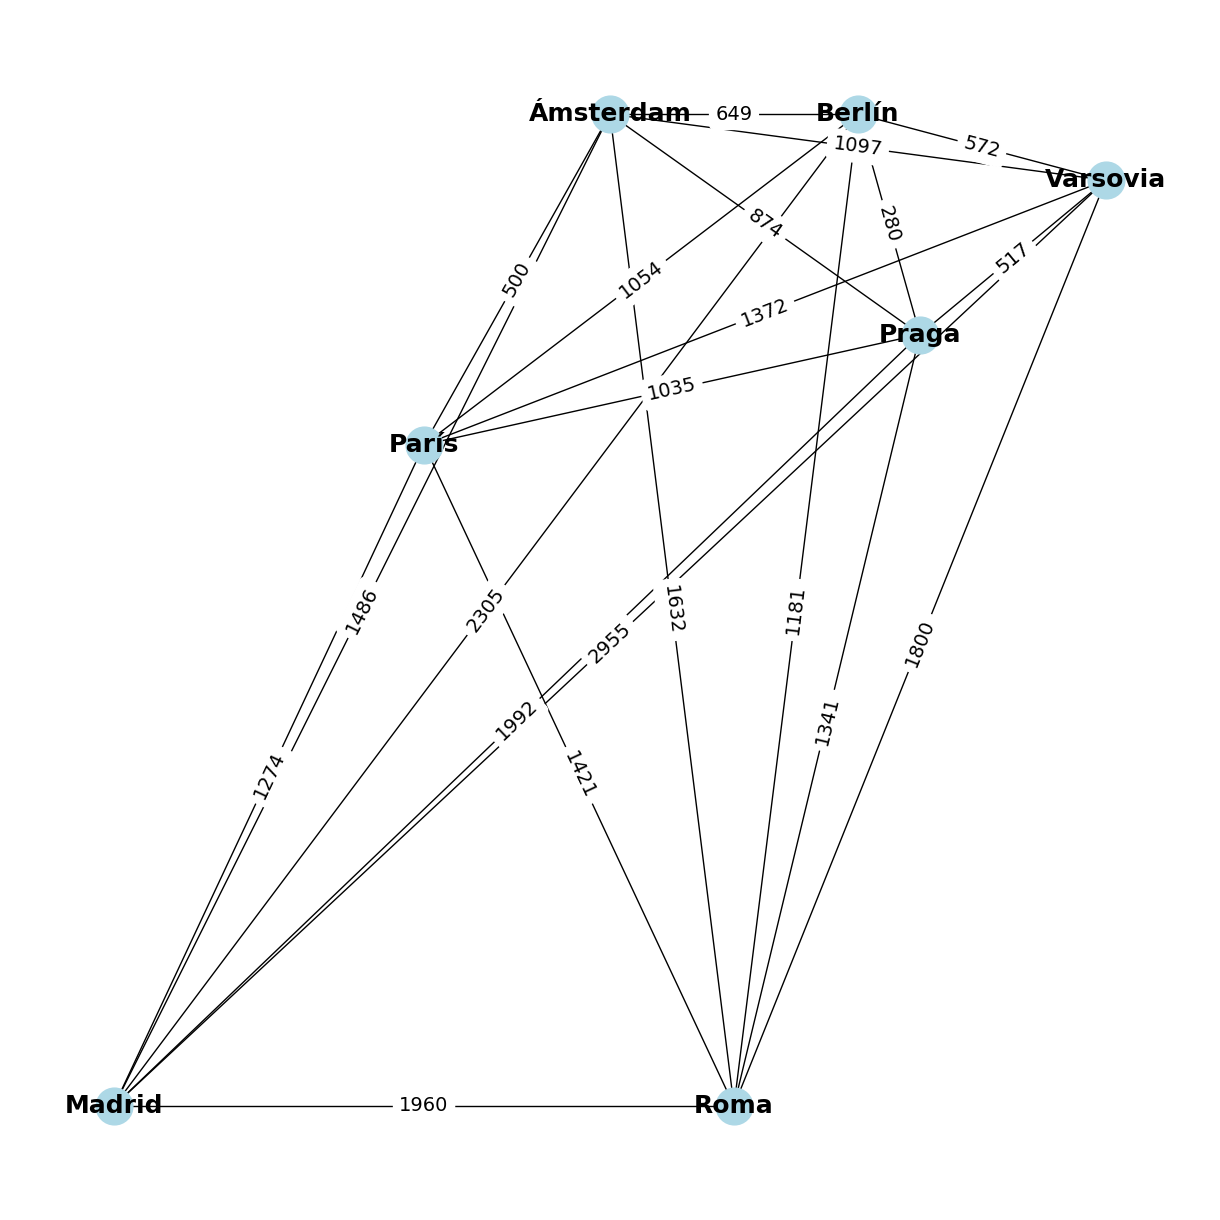

In [3]:
plt.figure(figsize=(12, 12))

nx.draw(G, coordenadas, with_labels=True, node_color='lightblue', font_weight='bold', node_size=700, font_size=18)
etiquetas = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, coordenadas, edge_labels=etiquetas, label_pos=0.5, font_size=14)

plt.show()

In [4]:
distancias = distancias.astype(float)
ciudades = distancias.index.tolist()

distancias

,París,Berlín,Madrid,Roma,Ámsterdam,Varsovia,Praga
París,0.0,1054.0,1274.0,1421.0,500.0,1372.0,1035.0
Berlín,1054.0,0.0,2305.0,1181.0,649.0,572.0,280.0
Madrid,1274.0,2305.0,0.0,1960.0,1486.0,2955.0,1992.0
Roma,1421.0,1181.0,1960.0,0.0,1632.0,1800.0,1341.0
Ámsterdam,500.0,649.0,1486.0,1632.0,0.0,1097.0,874.0
Varsovia,1372.0,572.0,2955.0,1800.0,1097.0,0.0,517.0
Praga,1035.0,280.0,1992.0,1341.0,874.0,517.0,0.0


## Definimos el Solver

In [5]:
solver = pywraplp.Solver.CreateSolver('CBC')

## Variables de decisión

\begin{align*}
x_{ij} =
\begin{cases}
1, & \text{si se viaja de la ciudad } i \text{ a la ciudad } j \\
0, & \text{en otro caso}
\end{cases}
\end{align*}

\begin{align*}
u_i = \text{orden de visita de la ciudad } i
\end{align*}

In [6]:
# Variables x
x = {}
for origen in ciudades:
    for destino in ciudades:
        if origen != destino:
            x[origen, destino] = solver.IntVar(0, 1, f'x_{origen}_{destino}')

# Variables u
u = {}
for ciudad in ciudades[1:]:  # Omitimos la primera ciudad
    u[ciudad] = solver.IntVar(1, len(ciudades) - 1, f'u_{ciudad}')

## Función objetivo

\begin{align*}
\text{Min } Z = \sum_{i \neq j} c_{ij} x_{ij}
\end{align*}

In [7]:
objective = solver.Objective()
for origen in ciudades:
    for destino in ciudades:
        if origen != destino:
            objective.SetCoefficient(x[origen, destino], distancias.at[origen, destino])
objective.SetMinimization()

## Restricciones

\begin{align*}
\text{1. Cada ciudad debe ser visitada exactamente una vez:}
\end{align*}

\begin{align*}
\sum_{i \neq j} x_{ij} = 1, \quad \forall j \in \text{Ciudades}
\\
\sum_{i \neq j} x_{ji} = 1, \quad \forall i \in \text{Ciudades}
\end{align*}

In [8]:
for ciudad in ciudades:
    solver.Add(sum(x[ciudad, destino] for destino in ciudades if ciudad != destino) == 1)
    solver.Add(sum(x[origen, ciudad] for origen in ciudades if ciudad != origen) == 1)

\begin{align*}
\text{2. Eliminación de subtours:}
\\
u_i - u_j + 7 x_{ij} \leq 6, \quad \forall i \neq j
\end{align*}

In [9]:
for origen in ciudades[1:]:
    for destino in ciudades[1:]:
        if origen != destino:
            solver.Add(u[origen] - u[destino] + len(ciudades) * x[origen, destino] <= len(ciudades) - 1)

## Resolución del problema

In [10]:
status = solver.Solve()

## Resultados

In [11]:
if status == pywraplp.Solver.OPTIMAL:
    print(f'Solución óptima encontrada con distancia total = {solver.Objective().Value()}')
    for origen in ciudades:
        for destino in ciudades:
            if origen != destino and x[origen, destino].solution_value():
                print(f'De {origen} a {destino}')
else:
    print('No se pudo encontrar una solución óptima.')

Solución óptima encontrada con distancia total = 6809.0
De París a Ámsterdam
De Berlín a Roma
De Madrid a París
De Roma a Madrid
De Ámsterdam a Varsovia
De Varsovia a Praga
De Praga a Berlín


In [12]:
for ciudad in ciudades[1:]:
    print(ciudad, u[ciudad].solution_value())

Berlín 4.0
Madrid 6.0
Roma 5.0
Ámsterdam 1.0
Varsovia 2.0
Praga 3.0
